In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from TX import upf
import subprocess
import os
from TX import bcc_rolling_fiber
vector_ang=bcc_rolling_fiber.vector_ang

     pf_for_lib is not available in the system
** joblib was not found - will not be used in TX.upf


## single point

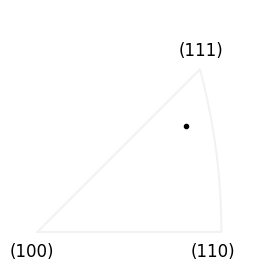

In [3]:
mypf=upf.polefigure(grains=[[0,35,30,1]],csym='cubic')
d=mypf.ipf(pole=[1,0,0],color='k',marker='.')

## calculate the arc of great circles between two crystal "plane normals"

In [4]:
!gfortran -c crystal_vectors.f -o crystal_vectors.o
!gfortran -c lib7.f -o lib7.o
!gfortran -c modified_crystal_symmetry.f -o crys_sym.o

In [5]:
dir_evpsc_repo='/Users/youngung/repo/evpsc/'
objfs=['chg_basis.o','voigt.o','fake_xit.o',#'data_crystal_fe.o',
       'funcs.o','lu_libs.o','lib_write.o',#'crystal_symmetry.o',
      'thermo_emod_cte.o','sx_version_tester.o']
# append the location
for i, o in enumerate(objfs): objfs[i]=os.path.join(dir_evpsc_repo,'objdir',o)
for i, o in enumerate(objfs):
    print(os.path.isfile(o))
#    
comp_cmd='gfortran crystal_vectors.o lib7.o crys_sym.o'
for i, o in enumerate(objfs):
    comp_cmd=f'{comp_cmd} {o}'
comp_cmd=f'{comp_cmd} -o calc_cv'
print(f'comp_comd: {comp_cmd}')
p=subprocess.Popen(comp_cmd.split(),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
stdo,stde=p.communicate()
print(stdo.decode())
print(stde.decode())

True
True
True
True
True
True
True
True
comp_comd: gfortran crystal_vectors.o lib7.o crys_sym.o /Users/youngung/repo/evpsc/objdir/chg_basis.o /Users/youngung/repo/evpsc/objdir/voigt.o /Users/youngung/repo/evpsc/objdir/fake_xit.o /Users/youngung/repo/evpsc/objdir/funcs.o /Users/youngung/repo/evpsc/objdir/lu_libs.o /Users/youngung/repo/evpsc/objdir/lib_write.o /Users/youngung/repo/evpsc/objdir/thermo_emod_cte.o /Users/youngung/repo/evpsc/objdir/sx_version_tester.o -o calc_cv




In [6]:
ls ~/repo/evpsc/matData/vpscData/AA_jinhwa/sx_Al6061_affine.sx

/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/sx_Al6061_affine.sx


In [7]:
!./calc_cv ~/repo/evpsc/matData/vpscData/AA_jinhwa/sx_Al6061_affine.sx 1 1 1 1 1 0

  # of symmetry operations=  24
  symmetry matrices
  1  1.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  1.000
  2  0.000  0.000  1.000  1.000  0.000  0.000  0.000  1.000  0.000
  3  0.000  1.000  0.000  0.000  0.000  1.000  1.000  0.000  0.000
  4  0.000  1.000  0.000  1.000  0.000  0.000  0.000  0.000  1.000
  5  1.000  0.000  0.000  0.000  0.000  1.000  0.000  1.000  0.000
  6  0.000  0.000  1.000  0.000  1.000  0.000  1.000  0.000  0.000
  7 -0.000 -1.000  0.000  1.000 -0.000  0.000  0.000  0.000  1.000
  8 -1.000  0.000 -0.000 -0.000  0.000  1.000  0.000  1.000  0.000
  9  0.000 -0.000 -1.000  0.000  1.000 -0.000  1.000  0.000  0.000
 10 -1.000 -0.000  0.000 -0.000  1.000  0.000  0.000  0.000  1.000
 11 -0.000  0.000 -1.000  1.000  0.000 -0.000  0.000  1.000  0.000
 12  0.000 -1.000 -0.000  0.000 -0.000  1.000  1.000  0.000  0.000
 13 -1.000  0.000  0.000 -0.000 -1.000  0.000  0.000  0.000  1.000
 14  0.000  0.000 -1.000 -1.000  0.000 -0.000  0.000  1.000  0.000
 15  0.000

In [67]:
def calc_cvec(miller,fnsx):
    """
    Get a crystal vector of a Miller-indexed plane normal
    """
    cmd=f'./calc_cv {fnsx}'
    for i, ind in enumerate(miller): cmd=f'{cmd} {ind}'
    cmd=f'{cmd}  '
    #print(f'cmd: {cmd}')
    p=subprocess.Popen(cmd.split(),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    stdo,stde=p.communicate()
    #print(f'\n\n** stdo: {stdo.decode()}')
    lines=stdo.decode().split('\n')
    nsymop=int(lines[0].split('=')[-1])
    lines[1:2+nsymop]
    return np.array(lines[2+nsymop:][0].split(),dtype='float')
    #return np.array(stdo.decode().split('\n')[0].split(),dtype='float')

def calc_symop(fnsx):
    cmd=f'./calc_cv {fnsx}'
    miller=[1,0,0,0]
    for i, ind in enumerate(miller): cmd=f'{cmd} {ind}'
    cmd=f'{cmd}  '
    # print(f'cmd: {cmd}')
    p=subprocess.Popen(cmd.split(),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    stdo,stde=p.communicate()
    # print(f'\n\n** stdo: {stdo.decode()}')
    lines=stdo.decode().split('\n')
    nsymop=int(lines[0].split('=')[-1])
    lines=lines[2:2+nsymop]
    #print(lines[0])
    #print(lines[-1])
    #for i in range(3):
    h=np.zeros((nsymop,3,3))
    for m, line in enumerate(lines):
        d=np.array(line.split()[1:],dtype='float')
        k=0
        for i in range(3):
            for j in range(3):
                h[m,i,j]=d[k]
                k=k+1
        #print(f'h: {h[m,:,:]}')
    return h

def proj(a):
    #print(f'a.shape:, {a.shape}')
    #print(f'len(a.shape): {len(a.shape)}')
    if len(a.shape)>1:
        vs=a.copy()
    elif len(a.shape)==1:
        vs=np.zeros((1,3))
        vs[0,:]=a[::]
    nvec=vs.shape[0]
    coords=np.zeros((nvec,2))
    for i, v in enumerate(vs):
        coords[i,:]=upf.projection(v,[[0.,0.,0.,1]])
    if len(a.shape)>1: return coords            
    elif len(a.shape)==1: return coords[0]

def circ():
    ths=np.linspace(-pi,pi)
    x=cos(ths);   y=sin(ths)
    return x,y

def gen_fig(nrows=3,ncols=3,colsize=2.5,rowsize=2.,**kwargs):
    gs=GridSpec(nrows=nrows,ncols=ncols,**kwargs)
    fig=plt.figure(figsize=(colsize*ncols,rowsize*nrows))
    axes=np.empty((nrows,ncols),dtype='object')
    for i in range(nrows):
        for j in range(ncols):
            ax=fig.add_subplot(gs[i,j])
            axes[i,j]=ax
    return fig,axes

In [34]:
def calc_vref_and_rot(a,b,fnsx,nang):
    """
    Given a miller-indexed crystal plane normal (a and b),
    calclulate the v ref and rotation matrices vref.
    """
    aca=-calc_cvec(a,fnsx)
    #print(f'b in calc_vref_and_rot {b}')
    bca=-calc_cvec(b,fnsx)
    #print(f'bca in calc_vref_and_rot {bca}')
    ## reference vector
    vref=np.cross(aca,bca)
    #print(f'vref: {vref}')
    #print(f'aca: {aca}')

    ##
    thf=np.arccos(np.dot(aca,bca))
    #print(f'thf: {np.rad2deg(thf)}')
    ths=np.linspace(0,thf,nang)
    rots=np.zeros((nang,3,3))
    varc=np.zeros((nang,3))
    
    for i, th in enumerate(ths):
        rots[i,:,:]=vector_ang(vref,np.rad2deg(th))
    return aca, bca, thf, vref, rots
    
    
def calc_arc(aca,rots):#a,b,fnsx,nang):
    """
    Arguments
    ---------
    aca crystal direction
    rots: rotation matrix
    """

    #aca, bca, thf, verf, rot = calc_vref_and_rot(a,b,fnsx,nang)
    nang=rots.shape[0]
    v_arc=np.zeros((nang,3))
    for i,rot in enumerate(rots):
        v_arc[i,:]=np.dot(rot,aca)
    return v_arc


In [35]:
def get_ipf_boundary(
    a=[0,0,1],b=[1,0,1],c=[1,1,1],nres=5,
    fnsx=None):
    
    pairs=[[a,b],[b,c],[c,a]]
    coords=np.zeros((2,(nres-1)*3+1))

    for i, pair in enumerate(pairs[:3]):
        #varc,vref=calc_arc(*pair,fnsx,nres)
        #print(varc.shape)
        aca,bca,thf,vref,rots=calc_vref_and_rot(*pair,fnsx,nres)
        varc=calc_arc(aca,rots)
        xy=proj(varc)
        i0=i*(nres-1)
        i1=i0+nres-1
        #print(f'i0,i1, {i0,i1}')
        coords[:,i0:i1]=xy[0:-1,:].T
    coords[:,-1]=coords[:,0]
    return coords


In [142]:
def ipf_temp(**kw):
    """
    Create inverse pole figure boundaries (consisting of triangle and circle)
    """
    kw.update(nres=1000)
    bound1=get_ipf_boundary(**kw)
    bound2=upf.__circle__()
    bound2=np.array(bound2)
    return bound1, bound2

In [37]:
ls /Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/*.cmb

/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/al6061_100.cmb
/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/al6061_1000.cmb
/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/al6061_500.cmb


In [116]:
np.arctan2

<ufunc 'arctan2'>

In [144]:
def xy2_rtheta(x,y):
    """
    Convert from stereographically projected locations (X,Y)
    to that in 'R, Theta'
    """
    r=np.sqrt(x**2+y**2)
    th=np.arctan2(y,x)
    return r, th


In [169]:
ls /Users/youngung/repo/evpsc/examples/ex12_dd/uranium/uranium_voce.sx

/Users/youngung/repo/evpsc/examples/ex12_dd/uranium/uranium_voce.sx


## Choice of single crystal and texture

In [176]:
#kw=dict(a=[0,0,0,1],b=[1,0,-1,0],c=[2,-1,-1,0], fnsx='/Users/youngung/repo/evpsc/matData/vpscData/CP-Ti-ICN/dd_015.sx')
kw=dict(a=[0,0,1],b=[1,0,1],c=[1,1,1],fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/sx_Al6061_affine.sx')
#kw=dict(a=[0,0,1],b=[1,0,0],c=[0,1,0],fnsx='/Users/youngung/repo/evpsc/examples/ex12_dd/uranium/uranium_voce.sx')
#fnodf='/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/aa6061T6.odf'
fntx='/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/al6061_100.cmb'
#fntx='/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/al6061_1000.cmb'

(-4.71238898038469, 4.71238898038469)

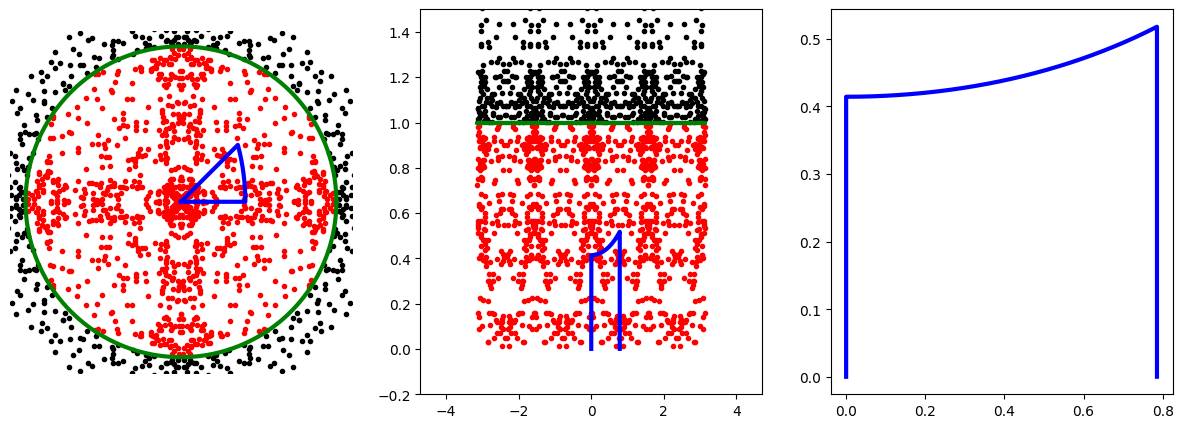

In [177]:
## canvas
fig,axes=gen_fig(nrows=1,ncols=3,colsize=5,rowsize=5)

## deco
triangle,circle=ipf_temp(**kw)
axes[0,0].plot(*triangle,'-b',lw=3,zorder=10)
axes[0,0].plot(*circle,'-g',lw=3,zorder=10)
r,t = xy2_rtheta(*triangle)
flg=r>0.00; r=r[flg]; t=t[flg]
axes[0,1].plot(t,r,'-b',lw=3,zorder=10)
axes[0,2].plot(t,r,'-b',lw=3,zorder=10)
r,t = xy2_rtheta(*circle)
axes[0,1].plot(t,r,'-g',lw=3,zorder=10)
##

csymop=calc_symop(fnsx=kw['fnsx']) ## crystal symmetry operator

mypf=upf.polefigure(filename=fntx,csym='cubic')
mypf.gr=mypf.gr[:100,:]

p_sa=[1,0,0] ## sample axis 1
p_sa=np.array(p_sa)
#p_sa=p_sa/np.sqrt((p_sa**2).sum())
dth=9.
dph=9.
p_ca=np.zeros((mypf.ngr,4))
# calculates its crystal direction
for i, gr in enumerate(mypf.gr):
    phi1,phi,phi2,wgt=gr[:4]
    amat=upf.euler(phi1,phi,phi2,a=None,echo=False) # ca <- sa
    p_ca[i,:3]=np.dot(amat,p_sa)
    p_ca[i,3]=wgt
    for iop, h in enumerate(csymop):
        p=np.dot(h,p_ca[i,:3])
        x,y=upf.projection(p)
        r,theta = xy2_rtheta(x,y)
        if p[2]<0: ## pointing to the south pole
            axes[0,0].plot(x,y,'r.')
            axes[0,1].plot(theta,r,'r.')
        if p[2]>=0:
            axes[0,0].plot(x,y,'k.')
            axes[0,1].plot(theta,r,'k.')

## Full Sphere (-pi, +pi) and (0, pi)                                                                                                                                                  
#x = np.arange(-180., 180.+tiny, dth) ## in-plane rotation                                                                                                                             
#y = np.arange(   0., 180.+tiny, dph) ## tilting                                                                                                                                       
nx, ny = int(360./dth), int(180./dph)
f = np.zeros((nx,ny))

## Semi Sphere (-pi, +pi) and (0, pi/2)                                                                                                                                                
tiny=1e-10
x_node = np.arange(-180.,180.+tiny,dth) ## in-plane rotation                                                                                                                           
y_node = np.arange(   0., 90.+tiny,dph) ## tilting                                                                                                                                     
nx_node = len(x_node); ny_node = len(y_node)
nodes = np.zeros((nx_node,ny_node))
#f = upf.pole2f(p_ca[:,:3],p_ca[:,3],dth,dph,f.copy())


axes[0,0].set_axis_off()
axes[0,0].set_aspect('equal')
axes[0,0].set_xlim(-1.1,1.1)
axes[0,0].set_ylim(-1.1,1.1)
axes[0,1].set_ylim(-0.2,1.5)
axes[0,1].set_xlim(-1.5*np.pi,1.5*np.pi)

In [ ]:
a=[0,0,1]
b=[1,0,1]
c=[1,1,1]
fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/sx_Al6061_affine.sx'
kw=dict(a=a,b=b,c=c,nres=5,
        fnsx=fnsx)

## inverse pole figure boundaries
boundary=get_ipf_boundary(**kw)
fig=plt.figure();ax=fig.add_subplot(111)
ax.plot(boundary[0],boundary[1],'k-o',mfc='None',alpha=0.2)
## Find arcs between a and b vectors
n_rad=6 ## from [0,0,1] towards the outer 
n_polar = 10
print(f'b in line 13: {b}')
aca, bca, thf_radian, vref, rots_rad_bottom = calc_vref_and_rot(a,b,fnsx,n_rad)
aca, cca, thf_radian, vref, rots_rad_top    = calc_vref_and_rot(a,c,fnsx,n_rad)

for i, rot in enumerate(rots_rad_bottom[1:,:,:]):
    rot_top = rots_rad_top[i+1,:,:]
    vref_ab=np.dot(rot,aca) ## 
    vref_ac=np.dot(rot_top,aca) ##
    l,=plot(*proj(vref_ab),'+')
    plot(*proj(vref_ac),'o',c=l.get_color())

    ## get arc between the bottom and top. (from bottom line towards top line)
    ths=np.linspace(0,thf,n_polar)
    rots_polar=np.zeros((n_polar,3,3))
        


## deco
ax.set_aspect('equal')
ax.set_axis_off()





In [ ]:
c=get_ipf_boundary(
    fnsx='/Users/youngung/repo/evpsc/matData/vpscData/CP-Ti-ICN/dd_015.sx',
    a=[0,0,0,1],
    b=[1,0,-1,0],
    c=[2,-1,-1,0])
fig=plt.figure();ax=fig.add_subplot(111)
ax.plot(c[0],c[1],'-')
ax.set_aspect('equal')
ax.set_axis_off()